In [112]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df =pd.read_csv('RSCCASN.csv',parse_dates=True,index_col='DATE')

In [114]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [116]:
df.columns=['Sales']

In [117]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


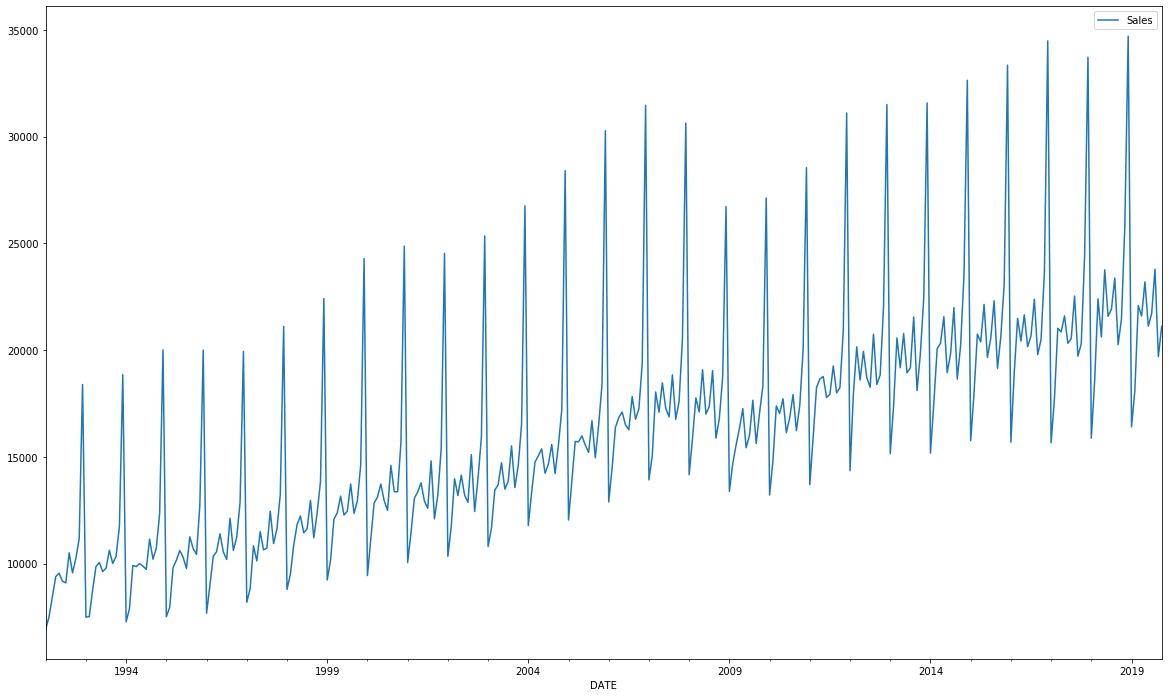

In [118]:
df.plot(figsize=(20,12))

In [119]:
#choose split for train at atleast a year before them cycle to predict willbe enough keep it 1.5
#month wise aahe so 12 rows = 1 year therfore 18 rows =1.5 years

len(df)-18

316

In [120]:
test_size=18

test_ind = len(df)-test_size

In [121]:
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]

In [122]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [123]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [124]:
from sklearn.preprocessing import MinMaxScaler 

In [125]:
scaler= MinMaxScaler()

In [126]:
scaler.fit(train)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [127]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [128]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [129]:
len(test)

18

In [130]:
length = 12

generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [131]:
X,y = generator[0]

In [132]:
X


array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [133]:
y

array([[0.02047633]])

In [134]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,GRU

n_features=1

In [135]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [136]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [137]:
from tensorflow.keras.callbacks import EarlyStopping 

In [138]:
early_stop =EarlyStopping(monitor='val_loss',patience=2)

In [139]:
validation_generator=TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [140]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

C:\Users\admin\anaconda3\envs\mytfenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 3s 6ms/step - loss: 0.0240 - val_loss: 0.0210
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0180 - val_loss: 0.0056
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0037 - val_loss: 9.3443e-04
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0047 - val_loss: 2.4380e-04
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0027 - val_loss: 8.3967e-04
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0015


In [141]:
losses =pd.DataFrame(model.history.history)

In [142]:
scaled_train[-length:] #last 12 from train 

array([[0.53252977],
       [0.48591345],
       [0.49364653],
       [0.56629393],
       [0.46405751],
       [0.48536886],
       [0.63534708],
       [0.97233517],
       [0.32468051],
       [0.42285071],
       [0.5615016 ],
       [0.49658728]])

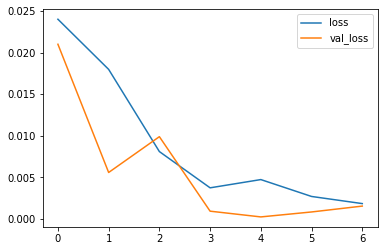

In [143]:
losses.plot()

In [144]:
test_predictions=[]

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_pred =model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [145]:
true_predictions=scaler.inverse_transform(test_predictions)

In [146]:
test['predications']=true_predictions

C:\Users\admin\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [147]:
test

,Sales,predications
DATE,,
2018-05-01,23764,22196.219118
2018-06-01,21589,21047.161341
2018-07-01,21919,21281.992384
2018-08-01,23381,23127.974820
2018-09-01,20260,20648.161011
2018-10-01,21473,21221.252547
2018-11-01,25831,25118.189948
2018-12-01,34706,35883.155107
2019-01-01,16410,17382.089161


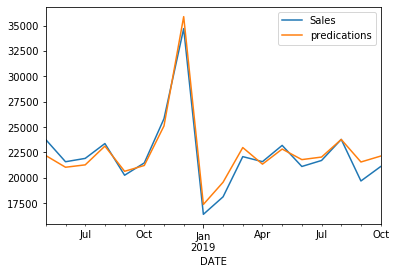

In [148]:
test.plot()

In [149]:
full_scaler=MinMaxScaler()

In [150]:
scaled_data=full_scaler.fit_transform(df)

In [151]:
length =12
generator = TimeseriesGenerator(scaled_data,scaled_data,length=length,batch_size=1)

In [152]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=11)

C:\Users\admin\anaconda3\envs\mytfenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/11
322/322 [==============================] - 3s 6ms/step - loss: 0.0233
Epoch 2/11
322/322 [==============================] - 2s 5ms/step - loss: 0.0173
Epoch 3/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0122
Epoch 4/11
322/322 [==============================] - 2s 5ms/step - loss: 0.0046
Epoch 5/11
322/322 [==============================] - 2s 5ms/step - loss: 0.0027
Epoch 6/11
322/322 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 7/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 8/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 9/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 10/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 11/11
322/322 [==============================] - 2s 6ms/step - loss: 0.0012


In [156]:
forecast=[]
periods=12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
    current_pred =model.predict(current_batch)[0]
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [158]:
forecast=scaler.inverse_transform(forecast)

In [159]:
forecast

array([[21503.82897282],
       [20328.01066589],
       [20587.25453615],
       [22473.29239655],
       [19952.63430214],
       [20522.86837149],
       [24696.22399282],
       [33873.8316474 ],
       [15993.9605217 ],
       [18527.72799253],
       [22203.43625212],
       [20532.02605486]])

In [160]:
forecast_index=pd.date_range(start='2019-11-01',periods=periods,freq="MS")

In [161]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [162]:
forecast_df=pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [163]:
forecast_df.head()

,Forecast
2019-11-01,21503.828973
2019-12-01,20328.010666
2020-01-01,20587.254536
2020-02-01,22473.292397
2020-03-01,19952.634302


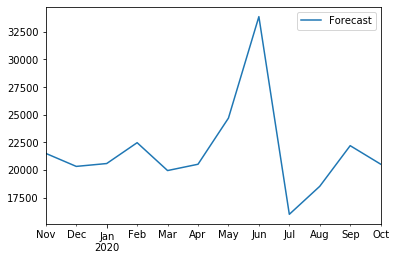

In [164]:
forecast_df.plot()

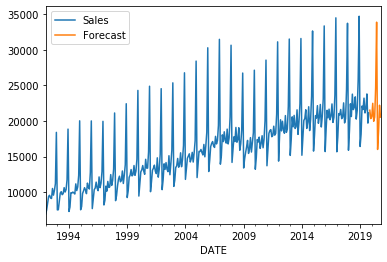

In [165]:
ax=df.plot()
forecast_df.plot(ax=ax)
plt.xlim()